In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pyam
from message_ix_models.tools.plotting.presentation_maker import ssp_plots
import importlib
import pickle

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
from pint import UnitStrippedWarning

warnings.simplefilter(action="ignore", category=UnitStrippedWarning)

from matplotlib.backends.backend_pdf import PdfPages
from message_ix_models.tools.plotting.presentation_maker.reporter_utils import (
    save_as_svg,
    get_all_ssp_pyam_df,
)

In [ ]:
# load from original excel files
path = "C:/Users/maczek/Desktop/SSP_dev reporting results/SSP_dev_13_results/"
ssp2_fname = f"SSP_dev_SSP2_v0.1_Blv0.13_baseline_prep_lu_bkp_solved_materials_v2_2025_macro.xlsx"
py_df_all = get_all_ssp_pyam_df(path, ssp2_fname)

In [11]:
# or load cached
with open("1000f_v2.p", "rb") as f:
    py_df_all = pickle.load(f)

In [17]:
with open("baseline_v2.p", "rb") as f:
    py_df_all2 = pickle.load(f)

In [ ]:
del py_df_all2

In [13]:
py_df_all = pyam.concat([py_df_all, py_df_all2])

## Final Energy by fuel

In [ ]:
vars = [
    "Final Energy|Industry|Electricity",
    "Final Energy|Industry|Solar",
    "Final Energy|Industry|Gases",
    "Final Energy|Industry|Solids|Coal",
    "Final Energy|Industry|Solids|Biomass",
    "Final Energy|Industry|Heat",
    "Final Energy|Industry|Hydrogen",
    "Final Energy|Industry|Liquids|Oil",
    "Final Energy|Industry|Liquids|Gas",
    "Final Energy|Industry|Liquids|Biomass",
    # "Final Energy|Industry|Liquids|Other",
]
regions = py_df_all.region[:-1]
regions = ["World"]
sectors = [
    "Chemicals",
    "Non-Ferrous Metals",
    "Steel",
    "Non-Metallic Minerals",
    "Other Sector",
]

In [ ]:
vars_new = [
    i
    for i in py_df_all.filter(
        variable="Final Energy|Industry|*", region="World"
    ).variable
    if not any(str in i for str in sectors)
]
vars_new = [i for i in vars_new if i.count("|") < 3]
vars_new

In [ ]:
py_df_all.aggregate(components=vars_new, variable="test").filter(
    region="World"
).timeseries()

In [ ]:
py_df_all.filter(variable="*Price*", region="World").variable

In [ ]:
py_df_all.filter(variable="Final Energy|Industry", region="World").timeseries()

In [ ]:
importlib.reload(ssp_plots)
sectors = [
    "Chemicals",
    "Non-Ferrous Metals",
    "Steel",
    "Non-Metallic Minerals",
    "Other Sector",
]

figs = {}
for reg in regions:
    with PdfPages(f"fe_ind_areaplots_1000f_{reg}.pdf") as pdf:
        fig = ssp_plots.plot_ssp_layout(py_df_all, vars)
        pdf.savefig(fig, bbox_inches="tight")
        figs[vars[0]] = fig

        for sector in sectors:
            vars_sec = [var.replace("Industry", f"Industry|{sector}") for var in vars]
            # print(ssp_plots.common_starting_substring(vars_sec))
            # print(vars_sec)
            fig = ssp_plots.plot_ssp_layout(py_df_all, vars_sec)
            pdf.savefig(fig, bbox_inches="tight")
            figs[sector] = fig
        plt.close()

save_as_svg("Final_Energy_Fuel", figs)

In [ ]:
b = "Final Energy|Industry"

for var in vars:
    print(var)
    py_df_all.divide(var, b, name=var + "|Share", append=True, ignore_units=True)

In [ ]:
figs = {}
vars2 = [i + "|Share" for i in vars]
for reg in regions:
    fig = ssp_plots.plot_ssp_layout(py_df_all, vars2)
    for ax in fig.axes:
        ax.set_ylabel("")
        # pdf.savefig(fig, bbox_inches="tight")
    figs[vars[0]] = fig

In [ ]:
figs[list(figs.keys())[0]].savefig("share_1000f.svg", bbox_inches="tight")

### Process + Feedstock

In [ ]:
fig, ax = plt.subplots(3, 4, figsize=(30, 30))
ax_it = iter(fig.axes)
print(vars)

for reg in py_df_all.Region.unique():
    ax = next(ax_it)
    print(
        py_df_all.filter(scenario=scenario, variable=vars, region=reg).timeseries()
    )  # .plot.stack(ax=ax, title=reg, legend=False)

### Process

In [ ]:
vars2 = [
    i.replace("Final Energy", "Final Energy|Industry excl Non-Energy Use") for i in vars
]
vars2 = [i.replace("Final Energy", "Final Energy|Industry|Steel") for i in vars]
vars2

In [ ]:
fig, ax = plt.subplots(3, 4, figsize=(32, 18))
ax_it = iter(fig.axes)
model = "SSP2"
for reg in py_df_all.region:
    if reg == "World":
        continue
    ax = next(ax_it)
    py_df_all.filter(variable=vars2, region=reg, model=model).plot.stack(
        ax=ax, title=reg, legend=False
    )
    ax.set_xlim(2015, 2115)

In [6]:
sectors = ["Non-Metallic Minerals", "Non-Ferrous Metals", "Chemicals", "Steel"]

In [ ]:
vars2 = [i.replace("Final Energy", f"Final Energy|Industry|{sectors[0]}") for i in vars]

## Final Energy - SSPs line plot

In [ ]:
importlib.reload(ssp_plots)
figs = {}
for reg in regions:
    with PdfPages(f"fe_ind_lineplots_1000f_{reg}.pdf") as pdf:
        var = "Final Energy|Industry"
        fig = ssp_plots.plot_triplet(py_df_all, var)
        fig.axes[4].set_ylabel("EJ / yr / M$")
        pdf.savefig(fig, bbox_inches="tight")
        figs[var] = fig

        for sector in sectors:
            fig = ssp_plots.plot_triplet(py_df_all, var + "|" + sector)
            fig.axes[4].set_ylabel("EJ / yr / M$")
            pdf.savefig(fig, bbox_inches="tight")
            figs[sector] = fig
    plt.close()
save_as_svg(var.replace("|", "_"), figs)

## Production - SSPs line plot

In [ ]:
importlib.reload(ssp_plots)
figs = {}
for reg in regions:
    with PdfPages(f"prod_ind_lineplots_1000f_{reg}.pdf") as pdf:
        var = "Production|"
        for sector in sectors:
            var_name = var + sector
            if "Metallic" in sector:
                var_name += "|Cement"
            fig = ssp_plots.plot_triplet(py_df_all, var_name)
            fig.axes[4].set_ylabel("EJ / yr / M$")
            # pdf.savefig(fig, bbox_inches="tight")
            figs[var_name] = fig
    plt.close()
save_as_svg(var[:-1], figs)

In [6]:
sectors = ["Non-Metallic Minerals|Cement", "Non-Ferrous Metals", "Chemicals", "Steel"]

TypeError: Axes.set_title() missing 1 required positional argument: 'label'

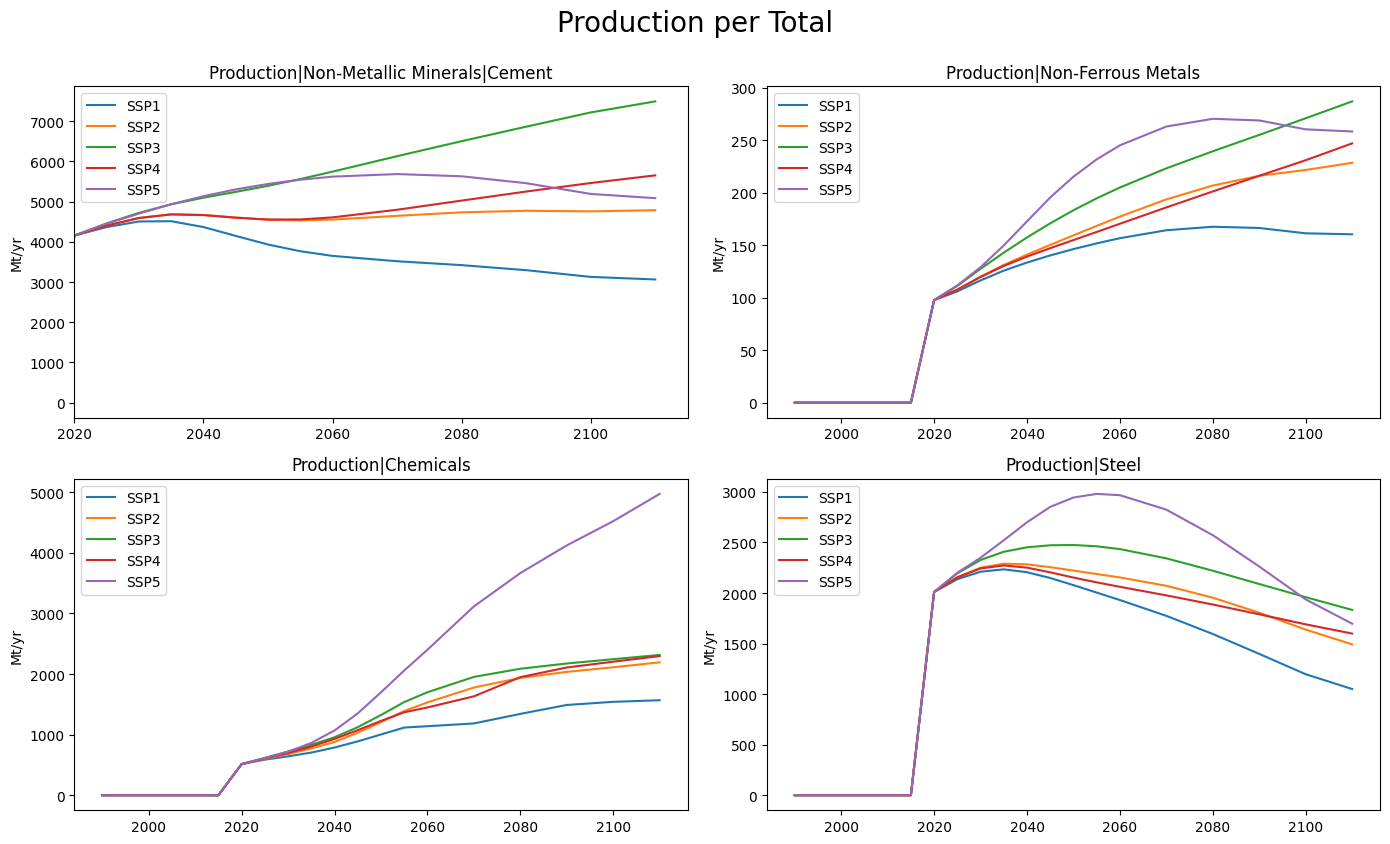

In [3]:
importlib.reload(ssp_plots)
figs = {}
regions = "World"
sectors = ["Non-Metallic Minerals|Cement", "Non-Ferrous Metals", "Chemicals", "Steel"]

for reg in regions:
    with PdfPages(f"prod_ind_lineplots_{reg}.pdf") as pdf:
        var_prefix = "Production|"
        vars = [var_prefix + i for i in sectors]
        fig = ssp_plots.plot_two_by_two(py_df_all, vars)  # , "GDP")
        for ax in fig.axes:
            ax.set_xlim(2020, 2115)
            ax.set_title()
            # ax.set_ylabel("Mt / yr / M$")
        # pdf.savefig(fig, bbox_inches="tight")
        figs[vars[0]] = fig
    # plt.close()
# save_as_svg("production_v2_total", figs)

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
py_df_all.filter(variable="Production|Primary|Chemicals|Ammonia", region="World").plot(
    ax=ax, title="Production|Primary|Chemicals|Ammonia"
)
ax.set_xlim(2020, 2115)
ax.set_ylim(150, 350)
fig.savefig("ammonia.svg", bbox_inches="tight")

## CO2 Emissions - SSPs line plot

In [ ]:
figs = {}
for reg in regions:
    with PdfPages(f"emi_ind_lineplots_1000f_{reg}.pdf") as pdf:
        var = "Emissions|CO2|Industry|"
        fig, ax = plt.subplots(2, 2, figsize=(16, 9))
        ax_it = iter(fig.axes)
        for sector in sectors:
            ax = next(ax_it)
            ssp_plots.ssp_pop_gdp_line_plot(py_df_all, var + sector).plot(
                title=sector, ax=ax
            )
            ax.set_xlabel("")
        pdf.savefig(fig, bbox_inches="tight")
        figs["sectors"] = fig

        fig, axs = plt.subplots(1, 2, figsize=(16, 9))
        ax_it = iter(fig.axes)
        for var in [
            "Emissions|CO2|Energy|Demand|Industry",
            "Emissions|CO2|Industrial Processes",
        ]:
            ax = next(ax_it)
            ssp_plots.ssp_pop_gdp_line_plot(py_df_all, var).plot(title=var, ax=ax)
        pdf.savefig(fig, bbox_inches="tight")

        figs["total"] = fig

    plt.close()

In [ ]:
save_as_svg("Emissions", figs)

### append industry emission aggregate to pyam df

In [14]:
a = "Emissions|CO2|Energy|Demand|Industry|"
b = "Emissions|CO2|Industrial Processes|"
new_var = "Emissions|CO2|Industry|"
for sector in sectors:
    py_df_all.aggregate(
        new_var + sector, components=[a + sector, b + sector], append=True
    )

## various checks

In [ ]:
vars = [
    i
    for i in py_df_all.filter(variable="Secondary Energy|Elec*").variable
    if len(i.split("|")) == 3
]
vars = [
    i for i in vars if not any(str in i for str in ["Non", "Trans", "Stor", "Foss"])
]
vars = [i for i in py_df_all.filter(variable="*Exp*").variable]
vars
for model in py_df_all.model:
    py_df_all.filter(variable=vars, region="WEU", model=model).plot.stack()

In [ ]:
figs = {}
for reg in regions:
    with PdfPages(f"emi_ind_lineplots_1000f_{reg}.pdf") as pdf:
        var = "Emissions|CO2|Industry|"
        fig, ax = plt.subplots(2, 2, figsize=(16, 9))
        for filter in ["*macro", "*1000f"]:
            py_df_all3 = py_df_all.filter(scenario=filter)
            ax_it = iter(fig.axes)
            for sector in sectors:
                ax = next(ax_it)
                ssp_plots.ssp_pop_gdp_line_plot(py_df_all3, var + sector).plot(
                    title=sector, ax=ax
                )
                ax.set_xlabel("")
            pdf.savefig(fig, bbox_inches="tight")
            figs["sectors"] = fig

        fig, axs = plt.subplots(1, 2, figsize=(16, 9))
        ax_it = iter(fig.axes)
        for var in [
            "Emissions|CO2|Energy|Demand|Industry",
            "Emissions|CO2|Industrial Processes",
        ]:
            ax = next(ax_it)
            ssp_plots.ssp_pop_gdp_line_plot(py_df_all3, var).plot(title=var, ax=ax)
        pdf.savefig(fig, bbox_inches="tight")

        figs["total"] = fig

    plt.close()

['baseline_prep_lu_bkp_solved_materials_v2_2025_macro']
['baseline_prep_lu_bkp_solved_materials_v2_2025_macro_1000f']


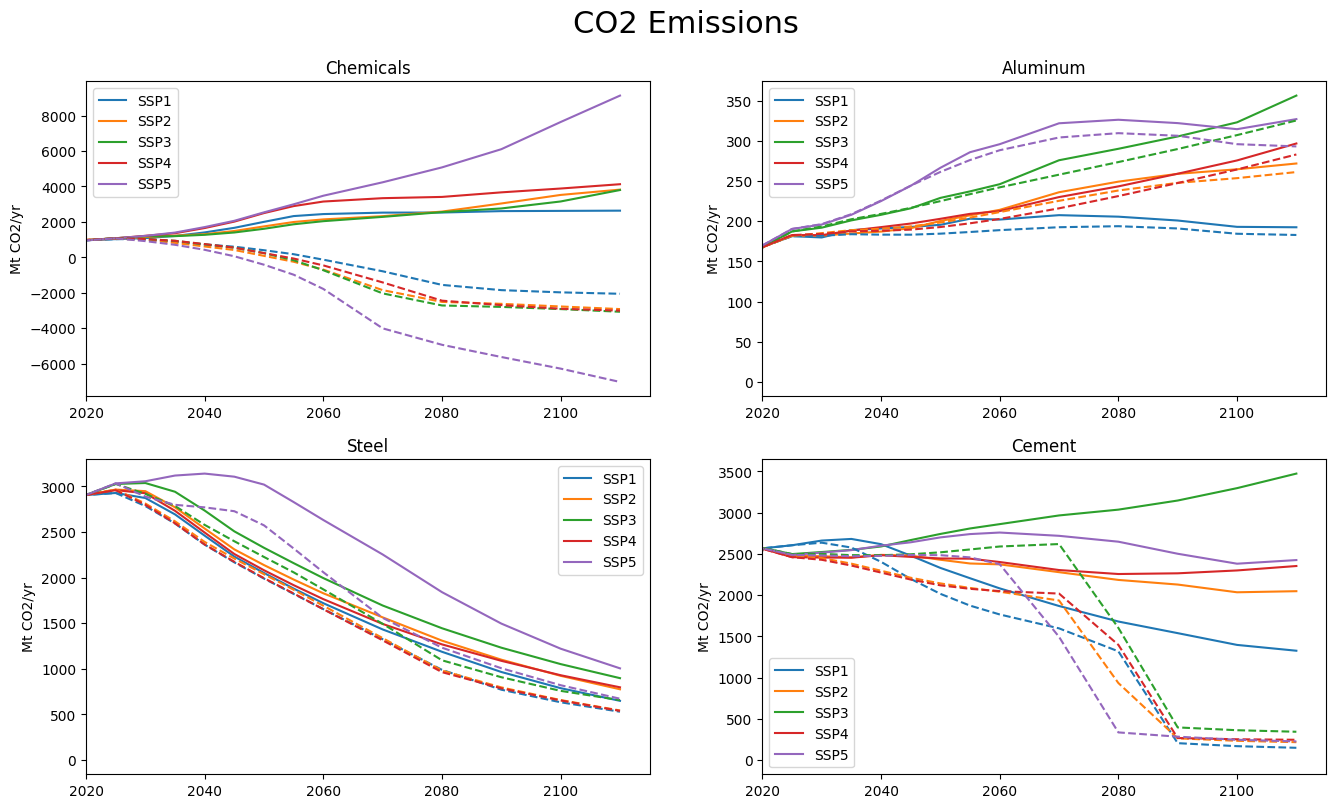

In [15]:
sectors = ["Chemicals", "Non-Ferrous Metals", "Steel", "Non-Metallic Minerals|Cement"]
var = "Emissions|CO2|Industry|"
figs = {}
fig, ax = plt.subplots(2, 2, figsize=(16, 9))
for filter, ls in zip(["*macro", "*1000f"], ["solid", "--"]):
    py_df_all_tmp = py_df_all.filter(scenario=filter)
    print(py_df_all_tmp.scenario)
    ax_it = iter(fig.axes)
    for sector, title in zip(sectors[:4], ["Chemicals", "Aluminum", "Steel", "Cement"]):
        ax = next(ax_it)
        ssp_plots.ssp_pop_gdp_line_plot(py_df_all_tmp, var + sector).plot(
            title=title, ax=ax, linestyle=ls, color="model"
        )
        ax.set_xlabel("")
        ax.set_xlim(2020, 2115)
    # pdf.savefig(fig, bbox_inches="tight")
    fig.suptitle("CO2 Emissions", fontsize=22, y=0.96)
    figs["sectors"] = fig

In [16]:
fig.savefig("iamc_emi.svg", bbox_inches="tight")

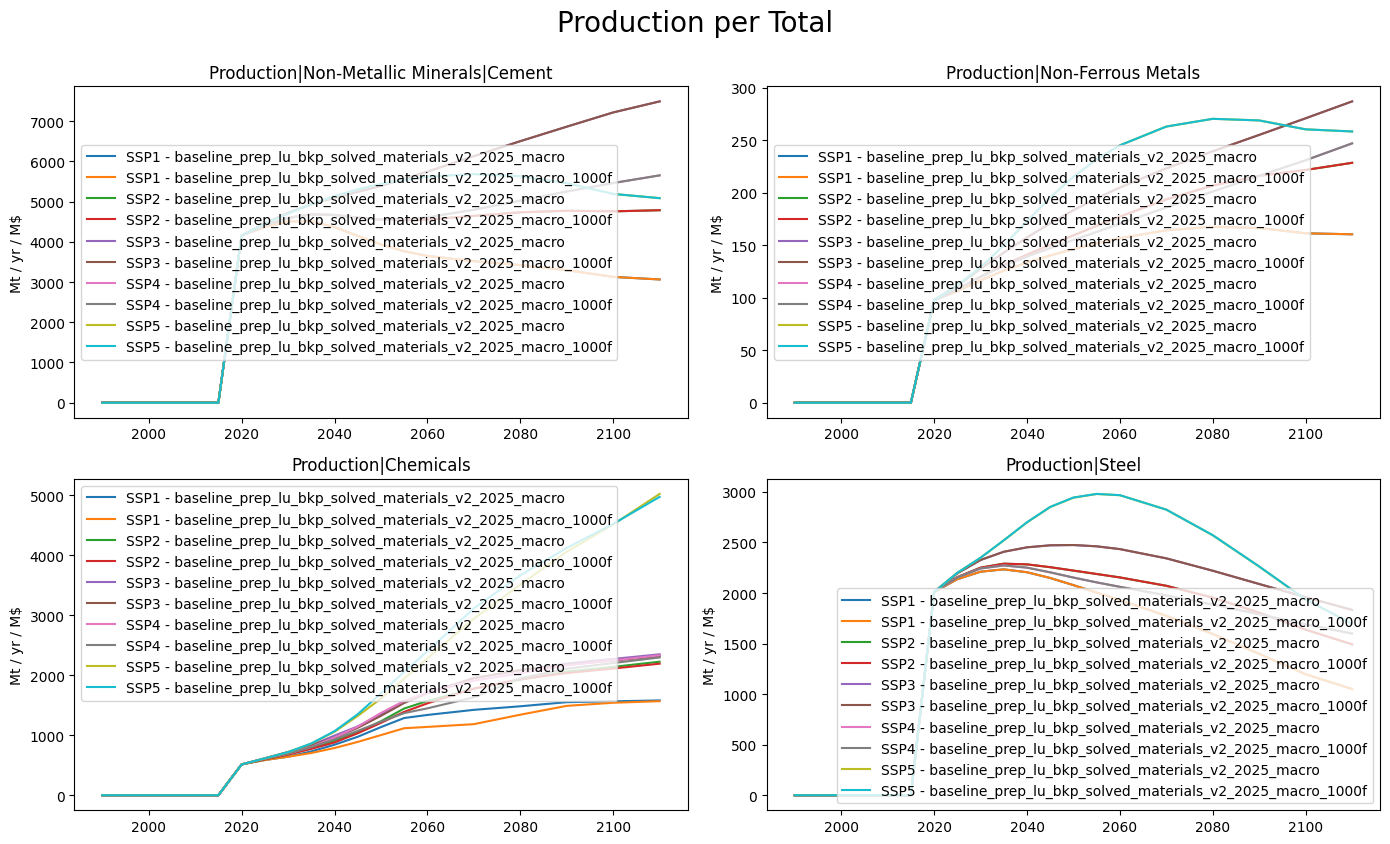

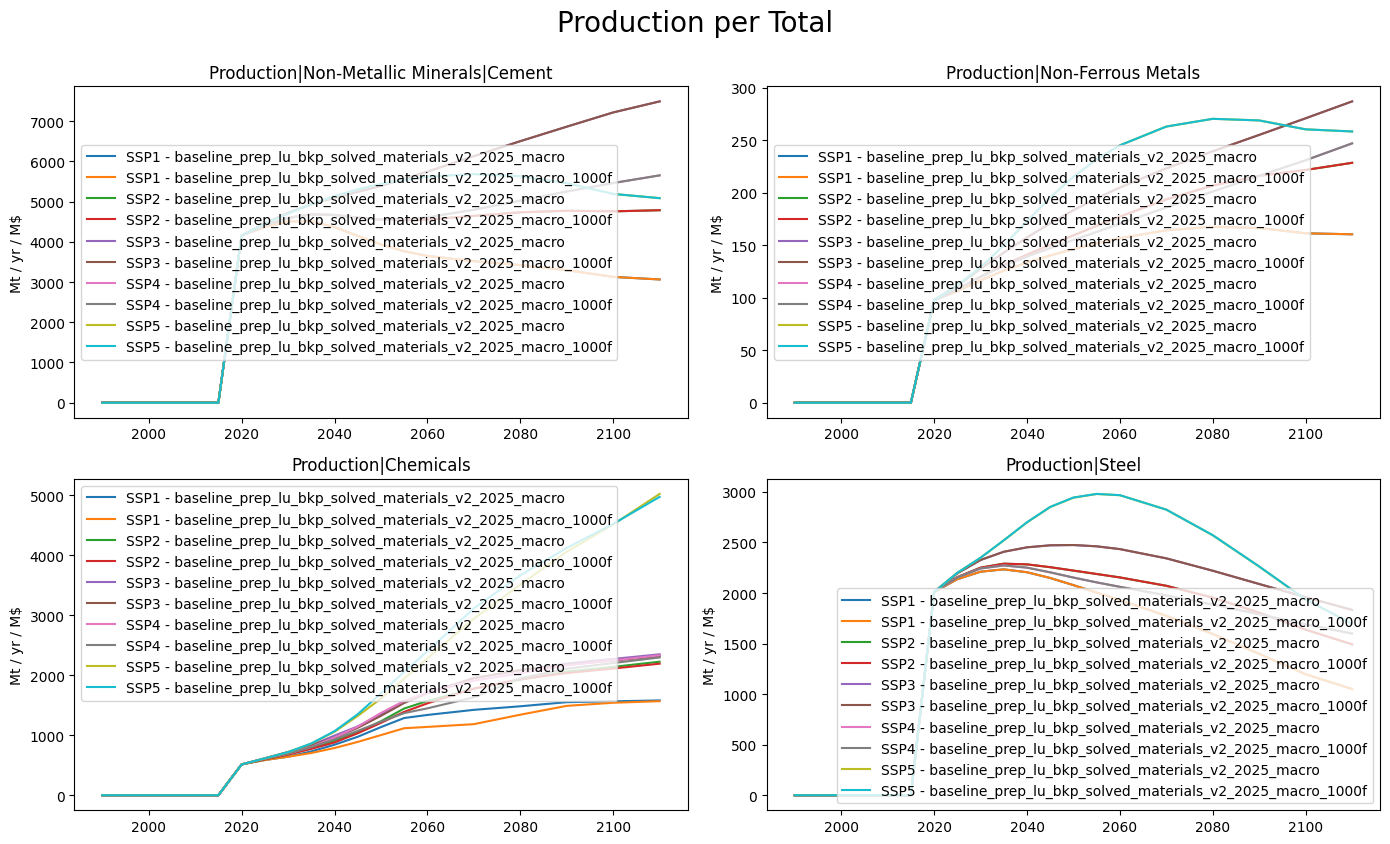

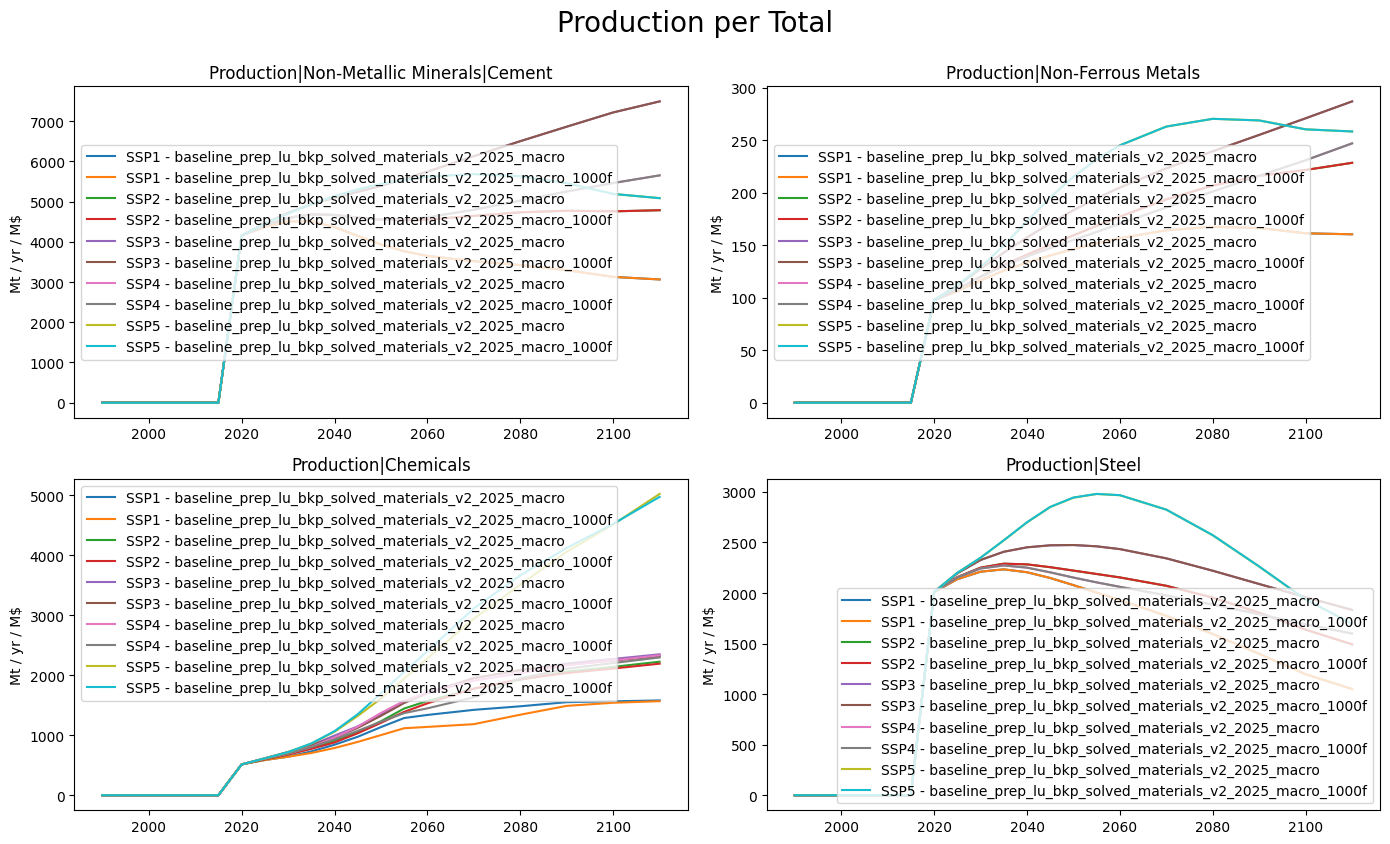

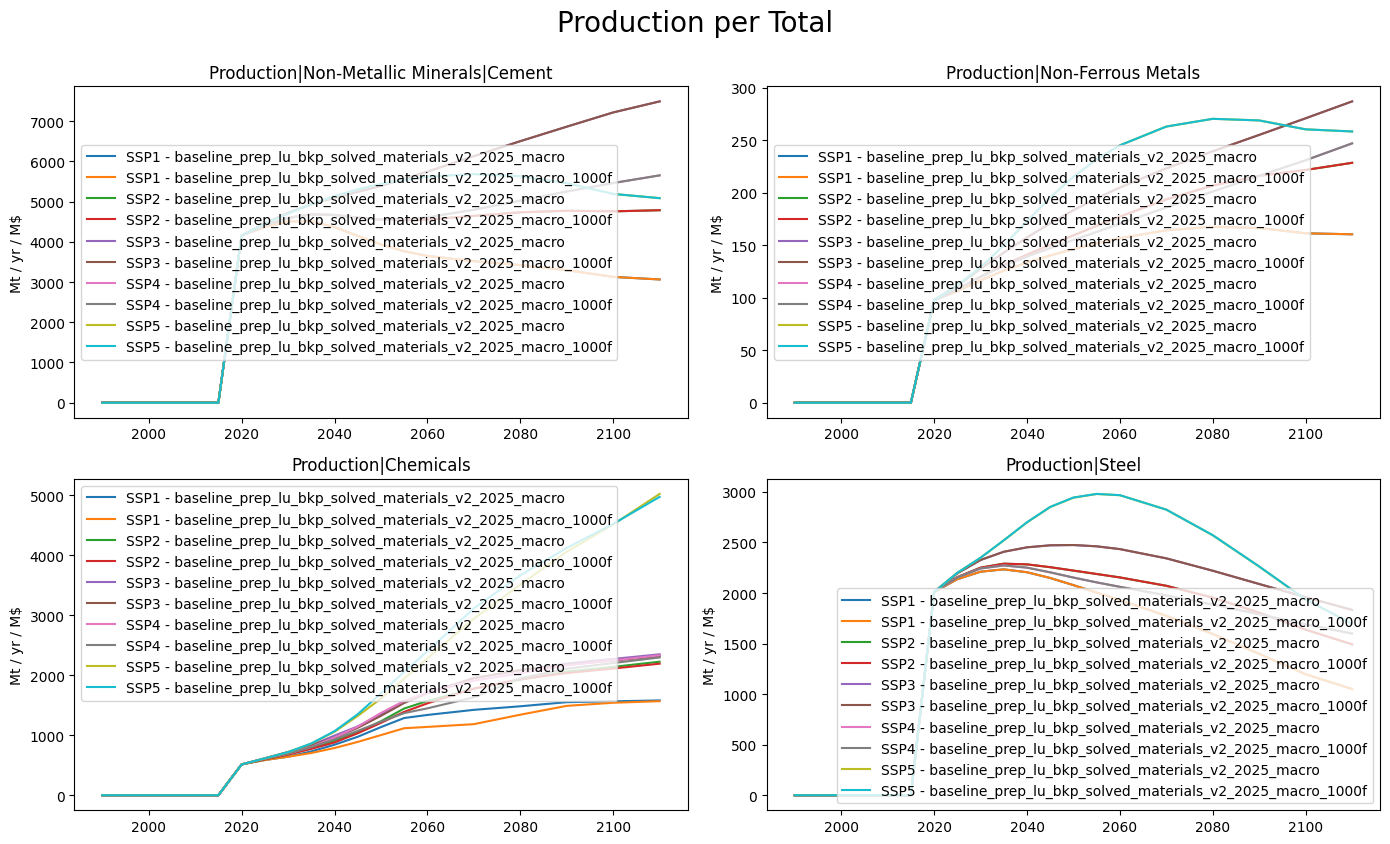

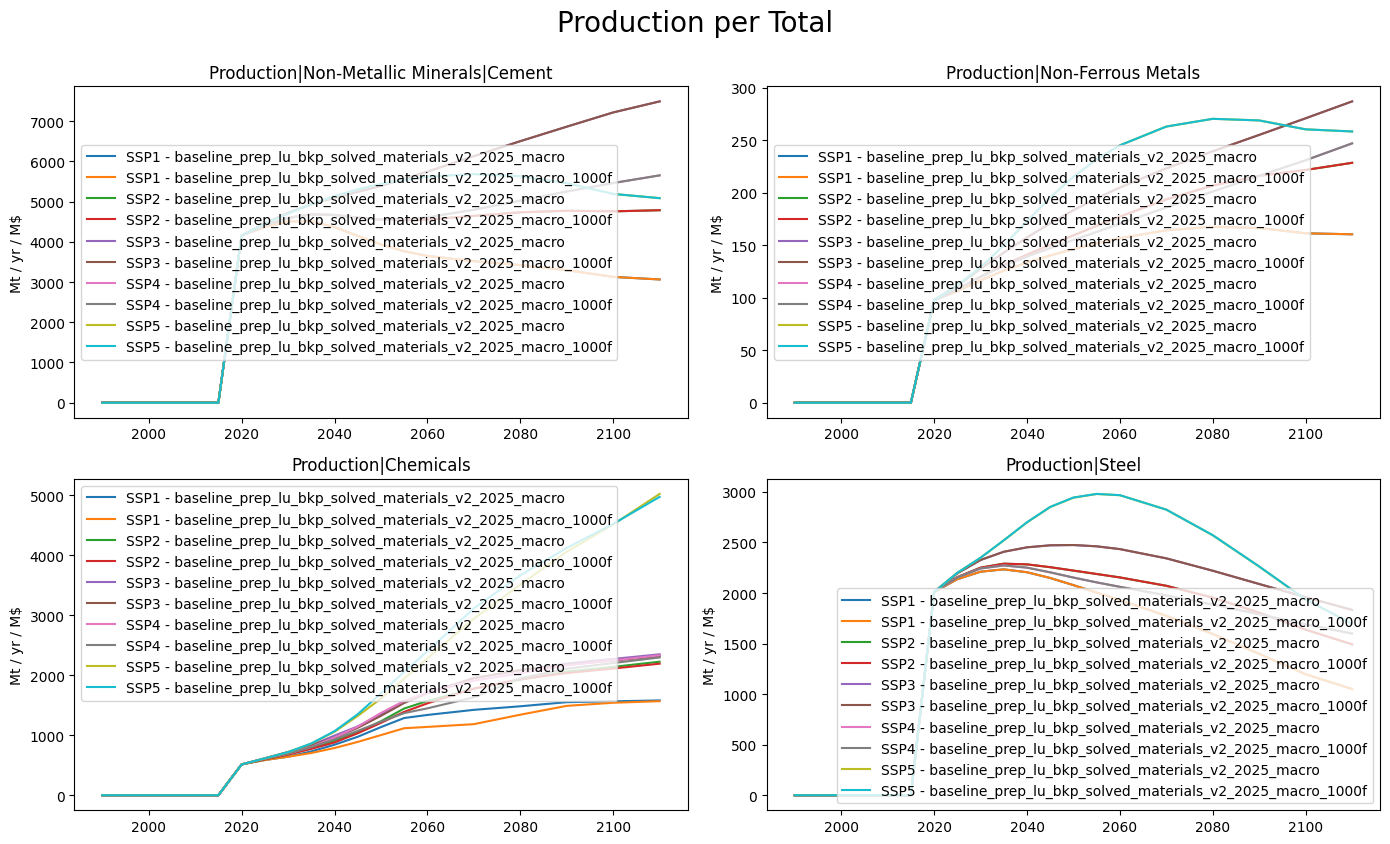

In [20]:
importlib.reload(ssp_plots)
figs = {}
regions = "World"
sectors = ["Non-Metallic Minerals|Cement", "Non-Ferrous Metals", "Chemicals", "Steel"]

for reg in regions:
    # with PdfPages(f'prod_ind_lineplots_1000f_{reg}.pdf') as pdf:
    var_prefix = "Production|"
    vars = [var_prefix + i for i in sectors]
    fig = ssp_plots.plot_two_by_two(py_df_all, vars)
    for ax in fig.axes:
        ax.set_ylabel("Mt / yr / M$")
    # pdf.savefig(fig, bbox_inches="tight")
    figs[vars[0]] = fig
    # plt.close()

AttributeError: 'NoneType' object has no attribute 'endStream'

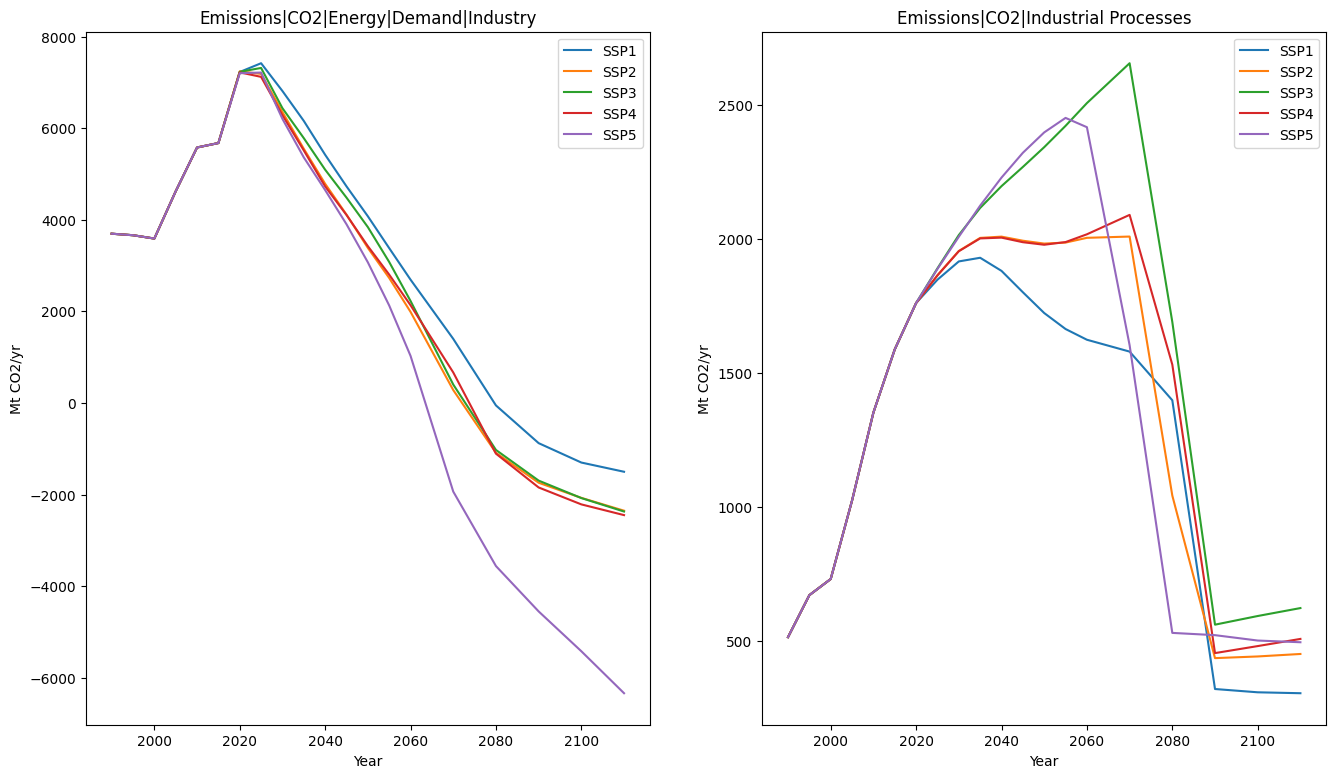

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(16, 9))
ax_it = iter(fig.axes)
for var in [
    "Emissions|CO2|Energy|Demand|Industry",
    "Emissions|CO2|Industrial Processes",
]:
    ax = next(ax_it)
    ssp_plots.ssp_pop_gdp_line_plot(py_df_all3, var).plot(title=var, ax=ax)
pdf.savefig(fig, bbox_inches="tight")

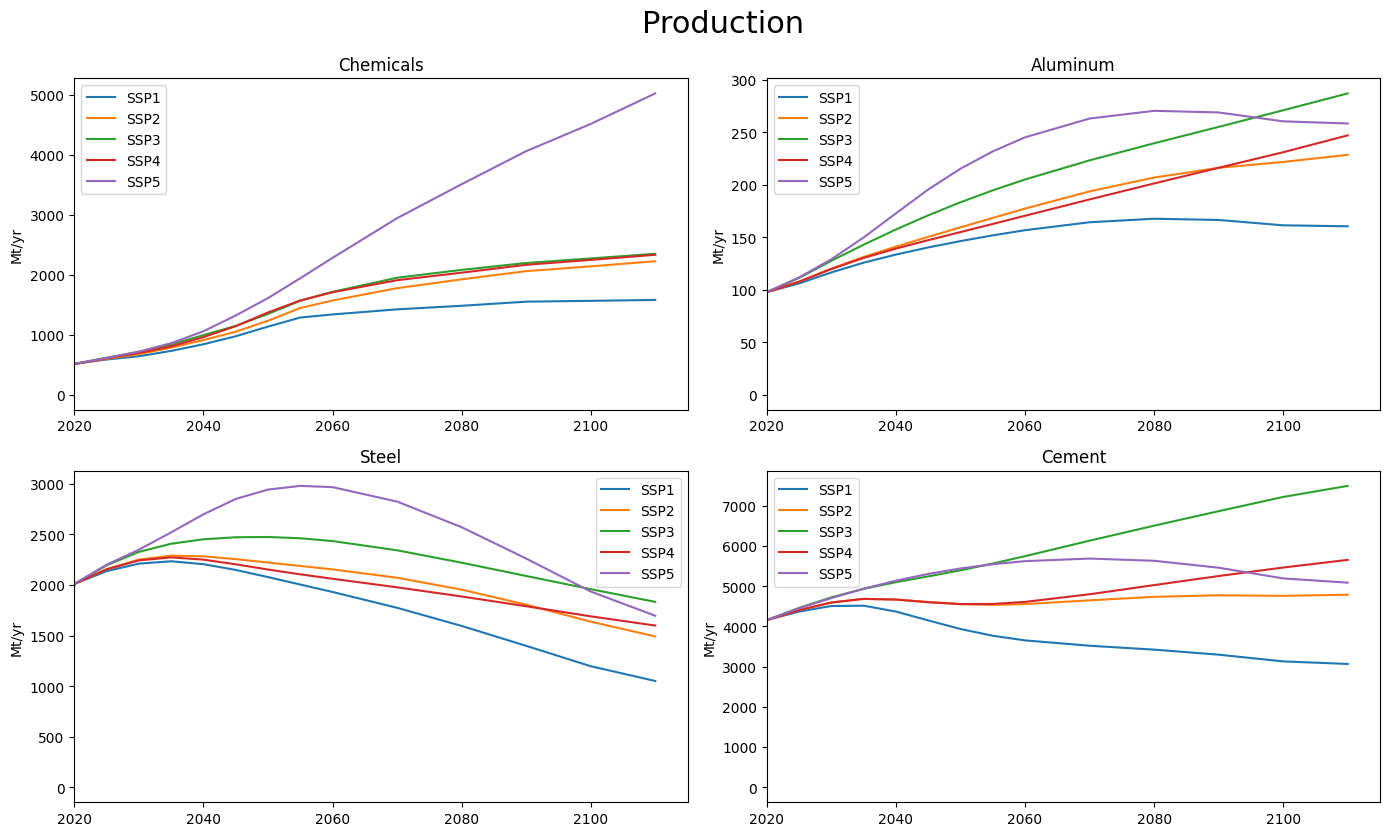

In [20]:
importlib.reload(ssp_plots)
figs = {}
regions = ["World"]
sectors = ["Chemicals", "Non-Ferrous Metals", "Steel", "Non-Metallic Minerals|Cement"]

for reg in regions:
    with PdfPages(f"prod_ind_lineplots_{reg}.pdf") as pdf:
        var_prefix = "Production|"
        vars = [var_prefix + i for i in sectors]
        fig = ssp_plots.plot_two_by_two(py_df_all, vars)  # , "GDP")
        for ax, title in zip(fig.axes, ["Chemicals", "Aluminum", "Steel", "Cement"]):
            ax.set_xlim(2020, 2115)
            ax.set_title(title)
            # ax.set_ylabel("Mt / yr / M$")
        # pdf.savefig(fig, bbox_inches="tight")
        fig.suptitle("Production", fontsize=22, y=1.04, x=0.52)
        figs[vars[0]] = fig
    # plt.close()
# save_as_svg("production_v2_total", figs)
fig.savefig("iamc_prod.svg", bbox_inches="tight")